# Elasticsearch と OpenAI を使用したセマンティック検索と取得の拡張生成

- Livedoor コーパス データセットを Elasticsearch にインデックス付け
- Transformarモデルに質問を埋め込み。
- エンコードされた質問を使用して、Elasticsearch インデックスでセマンティック検索を実行。
- 上位の検索結果を OpenAI [Chat Completions](https://platform.openai.com/docs/guides/gpt/chat-c​​ompletions-api) API エンドポイントに送信して、検索拡張生成 (RAG) を実現。

## パッケージをインストールしてモジュールをインポート

In [ ]:
%%capture
# capture will not print in notebook

import os
import sys

os.environ['CUDA_LAUNCH_BLOCKING']="1"

ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    !pip install "typing-extensions<4.6.0"
    !pip install openai
    !pip install pandas==1.5.3
    !pip install wget
    !pip install elasticsearch
    !pip install llama_index
    !pip install langchain==0.0.339
    !pip install unstructured
    !pip install faiss-cpu
    !pip install transformers sentencepiece fugashi ipadic gensim
    !pip install boto3
    !apt install aptitude
    !aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
    !pip install mecab-python3==0.7
    !git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
    !echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a
    !pip install japanize-matplotlib

In [ ]:
import subprocess
cmd = 'echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
dict_path = (subprocess.Popen(cmd, stdout=subprocess.PIPE,shell=True).communicate()[0]).decode('utf-8')

In [ ]:
# langchain
from langchain.chat_models import AzureChatOpenAI, ChatOpenAI
from langchain import LLMChain
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.chains import RetrievalQA
from langchain.document_loaders import UnstructuredFileLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS

# import modules
from getpass import getpass
from elasticsearch import Elasticsearch, helpers
import wget, zipfile, pandas as pd, json, openai

# AWS
import boto3

# buildin
import re
import io
import os

import glob
import csv
import time
import cv2
import json
from shapely.geometry import MultiPoint
from PIL import Image, ImageDraw
import os

from time import sleep
import sys
from pathlib import Path
from io import BytesIO

from tqdm.auto import tqdm
from PIL import Image

# pandas...etc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import MeCab
import itertools
import warnings
import re
import unicodedata
import collections
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import japanize_matplotlib
warnings.filterwarnings('ignore')

import IPython

## Elasticsearch に接続する

In [ ]:
ELASTIC_HOST = getpass("ELASTIC_HOST: ")
ELASTIC_API_KEY = getpass("ELASTIC_API_KEY: ")

client = Elasticsearch(
  endpoint=ELASTIC_HOST,
  api_key=ELASTIC_API_KEY
)

# Test connection to Elasticsearch
print(client.info())

ELASTIC_HOST: ··········
ELASTIC_API_KEY: ··········
{'name': 'instance-0000000001', 'cluster_name': '3ca78655565845aa9b436eec4dc0b34b', 'cluster_uuid': 'oJJ0fC81TFGPgZk9PDqTpQ', 'version': {'number': '8.14.1', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '93a57a1a76f556d8aee6a90d1a95b06187501310', 'build_date': '2024-06-10T23:35:17.114581191Z', 'build_snapshot': False, 'lucene_version': '9.10.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


## データセットをダウンロードする

このステップでは、NLP定番、livedoorニュースコーパス データセットをダウンロードし、zip ファイルを抽出します。

In [ ]:
df = pd.read_csv("news_train.csv")
df

title  \
0                                ピクサーが仕掛ける新たな挑戦とは？   
1                                ツイッターの“新掟”にユーザー困惑   
2            【週末映画まとめ読み】木下優樹菜「結婚生活は、できれば途中退場したくない」   
3                  【Sports Watch】斎藤佑樹が“イチロー化しつつある”   
4                      離婚歴のある男性との交際、過去はやっぱり気になるもの？   
...                                            ...   
3208                             TOKIOの出演CMに海外から非難   
3209     【週末映画まとめ読み】“ダークナイト”キャットウーマンの強烈バストにノックアウト！   
3210  【Sports Watch】ザック・ジャパン好発進の裏側で、本田の“ヒデ化”が火種に!?   
3211                      おかもとまり「私、枕営業したことないですから！」   
3212              ミス・フーターズ・ジャパンが1日限定“マリリン・モンロー”に変身   

                                                content        category  
0     　この夏、少女の勇気が試される！　設立25周年を迎えたディズニー／ピクサーが初めて“女性”を...     movie-enter  
1     ツイッターユーザーによって作られた“新ルール”に多くのユーザーが困惑している。\n\n騒動の...      topic-news  
2     　今週1週間に起こった出来事を振り返る「週末映画まとめ読み」。先週末の動員ランキングは2週連...     movie-enter  
3     プロ野球キャンプで一際注目を集めているのが、いわずもがな、北海道日本ハムファイターズの名護キ...    sports-watch  
4     現在独身でも、過去に「離婚歴がある」という人は、年代限らず珍しくない時代である。ちなみに厚生...  dokujo-tsushin  
...                                                 ...             ...  
3208  TOKIOが出演した「フードアクションニッポン」のCM「食べて応援しよう」の動画が今年1月末...      topic-news  
3209  　今週1週間に映画界で起こった出来事を紹介する「週末映画まとめ読み」。まずは、特にアクセス数...     movie-enter  
3210  今月8日、強豪アルゼンチン代表を下した、サッカー日本代表＝ザック・ジャパン。12日には、完全...    sports-watch  
3211  【おかもとまりの芸能界サバイバル塾】第1回講師：マシンガンズ\n\nお笑い界の片隅で必死にも...     movie-enter  
3212  　1963年8月5日、36歳の若さでこの世を去ったマリリン・モンロー。没後50年を迎えた今年...     movie-enter  

[3213 rows x 3 columns]

In [ ]:
df.describe()

title  \
count                                       3213   
unique                                      3209   
top     原著作者のクレジットを表示し、ニュース記事の改変をしないことを条件に、記事全文を   
freq                                           3   

                                                  content      category  
count                                                3213          3213  
unique                                               3211             5  
top     「今年の新人、使えないよね」「私もそう思ってた！」。新年度が始まって一段落つき、オフィスのあ...  sports-watch  
freq                                                    2           679

カテゴリカウント

sports-watch      679
it-life-hack      654
movie-enter       650
dokujo-tsushin    639
topic-news        591
Name: category, dtype: int64

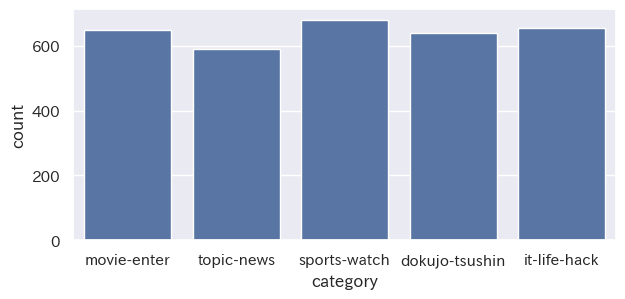

In [ ]:
plt.figure(figsize = (7, 3))
sns.countplot(x = df["category"])
df["category"].value_counts()

# **EDAと前処理**

In [ ]:
# 重複値を確認

title = df["title"]
df[title.isin(title[title.duplicated()])].sort_values("title")

#単純に重複している記事もあるし、同じ記事で複数のカテゴリーに分類されている場合もある

title  \
2547                          「愛している」と言っていますか？   
3000                          「愛している」と言っていますか？   
282                  アラサー独女が見た“バブルを引きずるアラフィフ女”   
1328                 アラサー独女が見た“バブルを引きずるアラフィフ女”   
835   原著作者のクレジットを表示し、ニュース記事の改変をしないことを条件に、記事全文を   
2669  原著作者のクレジットを表示し、ニュース記事の改変をしないことを条件に、記事全文を   
2772  原著作者のクレジットを表示し、ニュース記事の改変をしないことを条件に、記事全文を   

                                                content        category  
2547  年下の彼・和也さん（28歳）からの熱烈なアプローチで結婚した美也子さん（32歳）。幸せな毎日...  dokujo-tsushin  
3000  年下の彼・和也さん（28歳）からの熱烈なアプローチで結婚した美也子さん（32歳）。幸せな毎日...  dokujo-tsushin  
282   「今年の新人、使えないよね」「私もそう思ってた！」。新年度が始まって一段落つき、オフィスのあ...  dokujo-tsushin  
1328  「今年の新人、使えないよね」「私もそう思ってた！」。新年度が始まって一段落つき、オフィスのあ...  dokujo-tsushin  
835   自由に転載・引用が可能です。\n\nこのディレクトリの記事ファイル内容の提供元：\nMOVI...     movie-enter  
2669  自由に転載・引用が可能です。\n\nこのディレクトリの記事ファイル内容の提供元：\nITライ...    it-life-hack  
2772  自由に転載・引用が可能です。\n\nこのディレクトリの記事ファイル内容の提供元：\n独女通信...  dokujo-tsushin

In [ ]:
#重複値の削除
df = df.drop_duplicates(subset="title")

## **正規化**
テキストの正規化を行う。

In [ ]:
#unicodedataで数字、全角半角の正規化
df["content_preprocessed"] = (df["content"].str.lower().map(lambda x: unicodedata.normalize("NFKC", x)))

In [ ]:
df["content_preprocessed"][0]

' この夏、少女の勇気が試される! 設立25周年を迎えたディズニー/ピクサーが初めて“女性”を主人公に描く映画『メリダとおそろしの森』(7月21日より公開)の予告映像とポスタービジュアルが公開された。\n\n 本作の舞台は、太古の魔法が息づくスコットランドの神秘の森。馬を駆り、弓を射ることが大好きな主人公の王女メリダは、王家の伝統を重んじる厳格な母親としばしば対立していた。彼女は、王女としての責任から解放され、自由に生きることを夢見ていた。ある日、“鬼火”に導かれ、森の魔女の元へたどり着くと「運命を変えて欲しい」と魔女に頼む。しかし、太古の昔より人間が森の魔法を使うことはタブーとされており、魔女が呪文を唱えた時、恐るべき呪いが王国にかけられてしまう。果たしてメリダは、王国と愛する家族を救うことができるのか。\n\n 今回、公開された予告映像がこちら。\n\n\n 愛馬にまたがり颯爽と森を駆け抜けるメリダ、怪しく森の中へと誘う“鬼火”、メリダに襲い掛かる大きな熊など、魅力的なのキャラクターが、スケール感あふれる映像の中に次々と登場する。\n\n 『カールじいさんの空飛ぶ家』『トイ・ストーリー3』など、世界中で愛される傑作を生み出し続けるディズニー/ピクサーは、王女メリダと神秘的な“森”をどのように描くのか。\n\n 映画『メリダとおそろしの森』は、7月21日(土)より全国公開。\n\n・映画『メリダとおそろしの森』 - 公式サイト\n\n【関連記事】\n・『トイ・ストーリー』ファンが熱望した短編映画が日本上陸\n'

## **数字の扱い**
ニュースの分類タスクにおいて、数字は必要な情報ではないので、全ての数字を0に置換。

In [ ]:
def num_to_zero(text):
  text = re.sub(r"[0-9]+", "0", text)
  return text

df["content_preprocessed"] = df["content_preprocessed"].apply(num_to_zero)

In [ ]:
df["content_preprocessed"][0]

' この夏、少女の勇気が試される! 設立0周年を迎えたディズニー/ピクサーが初めて“女性”を主人公に描く映画『メリダとおそろしの森』(0月0日より公開)の予告映像とポスタービジュアルが公開された。\n\n 本作の舞台は、太古の魔法が息づくスコットランドの神秘の森。馬を駆り、弓を射ることが大好きな主人公の王女メリダは、王家の伝統を重んじる厳格な母親としばしば対立していた。彼女は、王女としての責任から解放され、自由に生きることを夢見ていた。ある日、“鬼火”に導かれ、森の魔女の元へたどり着くと「運命を変えて欲しい」と魔女に頼む。しかし、太古の昔より人間が森の魔法を使うことはタブーとされており、魔女が呪文を唱えた時、恐るべき呪いが王国にかけられてしまう。果たしてメリダは、王国と愛する家族を救うことができるのか。\n\n 今回、公開された予告映像がこちら。\n\n\n 愛馬にまたがり颯爽と森を駆け抜けるメリダ、怪しく森の中へと誘う“鬼火”、メリダに襲い掛かる大きな熊など、魅力的なのキャラクターが、スケール感あふれる映像の中に次々と登場する。\n\n 『カールじいさんの空飛ぶ家』『トイ・ストーリー0』など、世界中で愛される傑作を生み出し続けるディズニー/ピクサーは、王女メリダと神秘的な“森”をどのように描くのか。\n\n 映画『メリダとおそろしの森』は、0月0日(土)より全国公開。\n\n・映画『メリダとおそろしの森』 - 公式サイト\n\n【関連記事】\n・『トイ・ストーリー』ファンが熱望した短編映画が日本上陸\n'

### **形態素解析をステミング**
ステミング(stemming)：品詞の原型を取り出すこと<br>
例えば、「書きます」、「書く」、「書いた」、「書きました」の原型は全て「書く」になります。

In [ ]:
#ネットニュースデータなので、辞書はmecab-ipadic-neologdを使用（setupでパス定義済み）
mecab = MeCab.Tagger("-d {0} -Ochasen".format(dict_path))
mecab.parse("")

'EOS\n'

In [ ]:
def exclude_hinshi(text):

  result = []
  node = mecab.parseToNode(text)

  while node:
    if node.feature.split(",")[0] not in ["助詞", "記号", "助動詞", "接続詞", "連体詞", "動詞", "接頭詞"] and node.feature.split(",")[6] != "*":
      result.append(node.feature.split(",")[6])
    node = node.next

  return " ".join(result)


df["content_preprocessed"] = df["content_preprocessed"].apply(exclude_hinshi)

In [ ]:
df["content_preprocessed"][0]

'夏 少女 勇気 設立 周年 ディズニー ピクサー 初めて 女性 主人公 映画 メリダとおそろしの森 月 日 公開 予告映像 公開 本作 舞台 太古 魔法 スコットランド 神秘 森 馬 弓 こと 大好き 主人公 王女 MERIDA 王家 伝統 厳格 母親 しばしば 対立 彼女 王女 責任 解放 自由 こと ある日 鬼火 森 魔女 元 運命 欲しい 魔女 太古 昔 人間 森 魔法 こと タブー 魔女 呪文 時 呪い 王国 果たして メリダ 王国 家族 こと の 今回 公開 予告映像 こちら 愛馬 又借り 颯爽 森 メリダ 怪しい 森 中 鬼火 MERIDA 熊 魅力 的 キャラクター スケール 感 映像 中 次々 登場 カールじいさんの空飛ぶ家 トイ・ストーリー 世界中 傑作 ディズニー ピクサー 王女 メリダ 神秘 的 森 よう の 映画 メリダとおそろしの森 月 日 土 全国公開 映画 メリダとおそろしの森 公式サイト 関連 記事 トイ・ストーリー ファン 熱望 短編映画 日本 上陸'

## **ストップワードの除去**

In [ ]:
# ストップワードをダウンロード
!wget http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt

--2024-06-26 03:54:21--  http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt
Resolving svn.sourceforge.jp (svn.sourceforge.jp)... 44.240.209.230
Connecting to svn.sourceforge.jp (svn.sourceforge.jp)|44.240.209.230|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2202 (2.2K) [text/plain]
Saving to: ‘Japanese.txt’

Japanese.txt        100%[===================>]   2.15K  --.-KB/s    in 0s      

2024-06-26 03:54:22 (284 MB/s) - ‘Japanese.txt’ saved [2202/2202]



In [ ]:
#　ダウンロードしたファイルを読み込み
stopwords_file = open("Japanese.txt")
stopwords = [line.strip() for line in stopwords_file]
stopwords_file.close()

In [ ]:
def remove_stop_words(text):
  result = []
  node = mecab.parseToNode(text)

  while node:
    if node.surface not in stopwords:
      result.append(node.surface)
    node = node.next

  return " ".join(result)

df["content_preprocessed"] = df["content_preprocessed"].apply(remove_stop_words)

In [ ]:
df["content_preprocessed"][0]
#　月、日、こと、時など、ストップワードファイルに含まれていた単語は除去されました

'少女 勇気 設立 周年 ディズニー ピクサー 初めて 女性 主人公 映画 メリダとおそろしの森 公開 予告映像 公開 本作 舞台 太古 魔法 スコットランド 神秘 森 馬 弓 大好き 主人公 王女 MERIDA 王家 伝統 厳格 母親 しばしば 対立 王女 責任 解放 自由 ある日 鬼火 森 魔女 運命 欲しい 魔女 太古 昔 人間 森 魔法 タブー 魔女 呪文 呪い 王国 果たして メリダ 王国 家族 の 公開 予告映像 愛馬 又借り 颯爽 森 メリダ 怪しい 森 鬼火 MERIDA 熊 魅力 キャラクター スケール 映像 次々 登場 カールじいさんの空飛ぶ家 トイ・ストーリー 世界中 傑作 ディズニー ピクサー 王女 メリダ 神秘 森 の 映画 メリダとおそろしの森 全国公開 映画 メリダとおそろしの森 公式サイト 関連 記事 トイ・ストーリー ファン 熱望 短編映画 日本 上陸'

## **TF(Term Frequency)**
テキストデータの中身をより理解するために、頻繁に出現している単語を確認してみましょう。

In [ ]:
#形態素解析の結果から全体の単語出現頻度を出してみる

doc_freq_all = pd.Series(''.join(df.content_preprocessed).split(" ")).value_counts().to_frame("count")
doc_freq_all.head(15)

count
の   12381
ん    4015
ない   3305
映画   2736
0歳   2413
女性   1972
も    1873
記事   1815
多い   1806
日本   1785
いい   1717
公開   1612
関連   1383
作品   1323
氏    1320

In [ ]:
#情報量の少ない単語を取り除く

def remove_words(text):
  result = []
  node = mecab.parseToNode(text)

  while node:
    if node.surface not in ["の", "ん", "ない", "も"]:
      result.append(node.surface)
    node = node.next

  return " ".join(result)

df["content_preprocessed"] = df["content_preprocessed"].apply(remove_words)

頻繁に出現している単語は文書分類に役に立たなさそうなものもありますよね。<br><br>
全ての記事カテゴリーに頻繁に出現している単語は分類タスクにおいて必要な情報ではないので、<br>
TF-IDFで単語に重みを付けて、各カテゴリーの特徴をより良く理解しましょう。

## **TF-IDF特徴語抽出**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#tf-idfデータ準備：各カテゴリーの記事テキスト（前処理済み）をまとめる

text_dokujo = "".join(df["content_preprocessed"].loc[df.category == "dokujo-tsushin"])
text_news = "".join(df["content_preprocessed"].loc[df.category == "topic-news"])
text_sports = "".join(df["content_preprocessed"].loc[df.category == "sports-watch"])
text_movie = "".join(df["content_preprocessed"].loc[df.category == "movie-enter"])
text_it = "".join(df["content_preprocessed"].loc[df.category == "it-life-hack"])

tfidf_df = pd.DataFrame({"category": ["dokujo", "news", "sports", "movie", "it"], "text": [text_dokujo, text_news, text_sports, text_movie, text_it]})
tfidf_df

category                                               text
0   dokujo   現在 独身 過去 離婚 年代 珍しい 時代 厚生労働省 発表 離婚 統計 平成 離婚 総数...
1     news   Twitter ユーザー 新ルール ユーザー 困惑 騒動 発端 フォロワー Twitter...
2   sports   プロ野球 一際 注目 北海道日本ハムファイターズ 名護 ファン マスコミ 目当て 当然 ダ...
3    movie   少女 勇気 設立 周年 ディズニー ピクサー 初めて 女性 主人公 映画 メリダとおそろし...
4       it   ASUS モデル 弾 ノートパソコン eee pc 機種 モデル 発表 Ultrabook...

In [ ]:
#tf-idfを実行
vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
tfidf_matrix = vectorizer.fit_transform(tfidf_df["text"])
words = vectorizer.get_feature_names_out()

#形の確認
tfidf_matrix.shape

(5, 44555)

In [ ]:
#特徴的な単語を取得するための関数

def get_freq_word(category):
  freq_word = [words[i] for i in np.argsort(-tfidf_matrix.toarray()[tfidf_df[tfidf_df["category"] == category].index.values.item()])]
  return freq_word

In [ ]:
#各カテゴリー特徴語上位n個の取得
top_n = 20

print("dokujo: ", get_freq_word("dokujo")[:top_n])
print("news: ", get_freq_word("news")[:top_n])
print("sports: ", get_freq_word("sports")[:top_n])
print("movie: ", get_freq_word("movie")[:top_n])
print("it: ", get_freq_word("it")[:top_n])

# 微妙な単語も混じっているが、カテゴリーの特徴がはっきり分かれています
# もし事前にカテゴリー名を知らなくても、各カテゴリーにどういった内容になっているのかがイメージできます

dokujo:  ['0歳', '女性', '独女', '結婚', '男性', '多い', 'いい', '仕事', '代', '好き', '相手', 'さ', '恋愛', 'に', '気持ち', 'どう', '仮名', '夫', '笑', '心']
news:  ['ネット掲示板', '関連', '記事', '声', '情報', '韓国', '日本', '氏', '批判', '話題', '多い', 'akb', '発言', '意見', 'twitter', '番組', 'livedoor', 'blog', '放送', 'ユーザー']
sports:  ['選手', '氏', '試合', '日本', '監督', '日本代表', 'いい', '放送', 'チーム', '週刊アサヒ芸能', 'コメント', '位', '戦', '野村', '番組', 'w杯', '僕', '0歳', 'tbs', '本田']
movie:  ['映画', '公開', '本作', '作品', '監督', 'enter', '日本', '役', '特集', '登場', '位', '主演', '世界', '映像', '劇場', '記事', '作品情報', 'シーン', 'avengers', 'すごい']
it:  ['iphone', '機能', '製品', 'アプリ', 'pc', '容量', 'deji', '画面', '搭載', '写真', 'ultrabook', 'バッテリー', '0g', '対応', '記事', 'ユーザー', 'usb', '表示', 'サービス', '接続']


## **トピックモデル：LDA**
[LDA（Latent Dirichlet Allocation）](https://radimrehurek.com/gensim/models/ldamodel.html)はよく使われているトピックモデルの一つです。<br><br>
▼特徴<br>
・教師なし<br>
・クラスタリングしたいカテゴリー数を指定する必要がある<br>
・各カテゴリーの代表的な単語を抽出することができる<br><br>

▼使い所の例<br>
・トピック抽出：手元のデータにはどのようなトピックがあるのか<br>
・トピックをより細分化したい：「スポーツ」記事カテゴリーの中にも複数サブトピックがあるかもしれない、それはどういったものなのか<br>
・文書内容の傾向の変化を把握したい：5年前のニューストピックと現在のトピックはどう変わったのか




In [ ]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

In [ ]:
#記事を単語のリストに変換
article_list = [article.split() for article in df["content_preprocessed"]]

#単語のセットを作成
dictionary = Dictionary(article_list)
print("ユニーク単語数： ", len(dictionary))

#出現記事数が10個以下（レアすぎる）、4割以上（共通しすぎる）の単語を取り除く
dictionary.filter_extremes(no_below=10, no_above=0.4)
print("レアすぎる、共通しすぎる単語を除去した後の単語数： ", len(dictionary))

corpus = [dictionary.doc2bow(wd) for wd in article_list]

#モデル学習、トピック数を5に設定
lda = LdaModel(corpus, num_topics=5)

ユニーク単語数：  45177
レアすぎる、共通しすぎる単語を除去した後の単語数：  6371


In [ ]:
#LDAの結果を見てみる、[(カテゴリー, 確率), (カテゴリー, 確率)]の形になっている
lda[corpus[1]]

[(3, 0.8918552), (4, 0.10049575)]

In [ ]:
#LDAの結果をdataframeに整理すると、文章の各カテゴリーの確率が確認できる
lda_df = pd.DataFrame(index = range(len(corpus)))

for c in range(5):
  lda_df[c] = 0.0

for i in range(len(corpus)):
  topic = lda[corpus[i]]
  for t,p in topic:
    lda_df.loc[i][t] = p

main_topic = lda_df.values.argmax(axis=1)
pd.crosstab(df.category, main_topic)
# LDAのクラスタリング結果は実際の分類とかなり異なりますが、比較的に綺麗に分けられているクラスターもあります

col_0             0    1    2    3    4
category                               
dokujo-tsushin   19   36  551    3   27
it-life-hack    129  110   64  250  100
movie-enter       4  510   23   56   57
sports-watch    542    6   15   60   56
topic-news       57   12  139  229  154

In [ ]:
#cluster3の代表的な単語を見てみましょう、確かに映画とIT関連の単語が入ってます
top_terms_category= []

for i, prob in lda.get_topic_terms(3, topn=20):
  top_terms_category.append(dictionary[int(i)])

print(top_terms_category)

['映画', '情報', '日本', '監督', '機能', '関連', '氏', '公開', '対応', 'Twitter', '世界', '登場', 'PC', 'ユーザー', '話題', '紹介', 'サービス', '画面', 'ファン', 'いい']


### **LDAでサブトピックを抽出**
ITカテゴリーの中のサブトピックは何があるのか？<br>


In [ ]:
target_category = [article.split() for article in  df["content_preprocessed"].loc[df.category == "it-life-hack"]]

dictionary_it = Dictionary(target_category)

corpus_it = [dictionary_it.doc2bow(wd) for wd in target_category]

num_topics = 5
lda_it = LdaModel(corpus_it, num_topics= num_topics)

for category in range(num_topics):
  top_terms_category_it= []
  for i, prob in lda_it.get_topic_terms(category, topn=10):
    top_terms_category_it.append(dictionary_it[int(i)])
  print(top_terms_category_it)
#各トピックの代表的な単語を見て、どういったサブトピックがありそうなのか？

['写真', '0g', '機能', '対応', 'バッテリー', 'PC', '製品', 'ユーザー', '容量', 'iPhone']
['機能', 'PC', '画面', '製品', '搭載', '表示', 'iPhone', '対応', '0g', '記事']
['画面', '表示', '機能', '設定', '対応', 'PC', '製品', '利用', '情報', 'ゲーム']
['iPhone', '機能', 'アプリ', '記事', '画面', 'PC', '写真', 'もっと', 'サービス', '対応']
['iPhone', 'アプリ', 'Google', '機能', '0g', '記事', '製品', 'PC', '画面', '容量']


## **Word Association Network**
Word associationとは、単語の共起関係です。<br>
文書の中によく同時に出現する単語（共起語）を知ることができます。<br><br>

単語の共起関係は、word association network（共起ネットワーク）という手法で可視化できます。今回は映画カテゴリーのデータでword association networkを実装してみましょう。


In [ ]:
import itertools
from collections import Counter

In [ ]:
#まずは単語ごとに分割した映画カテゴリーの記事リストに入れる
#単語ごとに分割する理由は、単語同士の共起関係を計算するので、データを単語単位にしないといけない
article_movie = [article.split() for article in df["content_preprocessed"].loc[df.category== "movie-enter"]]
#一個目の記事
print(article_movie[1])

['今週', '週間', '出来事', '週末', '映画', 'まとめ', '読み', '先週末', '動員', 'ランキング', '連続', '位', '怪物くん', '社会現象', '大人気', 'アニメ', '遂に', '映画化', 'けいおん', 'スピルバーグ', '監督', 'タンタンの冒険/ユニコーン号の秘密', '位', '初登場', '0歳', '目前', '電車', '運転手', '夢', '姿', '動作', 'RAILWAYS愛を伝えられない大人たちへ', '位', '登場', 'いよいよ', '今週末', '公開', '作品', '父', '息子', 'かけがえ', '絆', '感動', '大作', 'リアル・スティール', '公開', '鑑賞', 'タレント', '木下優樹菜', 'リアル・スティール', '強い', 'さ', 'FUJIWARA', '藤本', '夫婦生活', 'Enter', 'リアル・スティール', '特集', 'ページ', 'iPad', 'キャンペーン', '実施', '是非', '応募', 'ライダー', '生誕', '周年', 'イヤー', 'ラスト', '仮面ライダー', '仮面ライダー', 'フォーゼ', 'オーズ', 'MOVIE大戦', 'MEGA', 'MAX', 'オーズ', 'ヒロイン', '泉', '比奈', '役', '高田里穂', 'オーズ', '愛', '熱い', '今週', '映画', '動員', 'ランキング', 'インタビュー', '木下優樹菜', '強い', 'さ', 'リアル・スティール', '特集', 'ページ', 'インタビュー', '高田里穂', '仮面ライダーオーズ', 'ヒロイン', '公開', '作品', '一覧', '週間', 'Enter', '上半期', '下半期', '公開', '映画', '独断', '偏見', 'ベスト', '作品', '勝手', '表彰', '連続', '企画', 'トップバッター', 'ヒーロー', '妄想', 'canta', 'トップ', '発表', '劇場公開', 'Blu-Ray', 'DVD', 'チェック', '如何', '次回', '更新', 'ドラマ', 'サイトー', 'ベスト', '作品', '届け', '下半期

In [ ]:
# ２つの単語が同じ記事の中に一緒に出現した回数をカウントするリストを作成
pair_word = [list(itertools.combinations(i, 2)) for i in article_movie]

pair_word_no_self = []
for p in pair_word:
  pair_word_no_self.append(list((w1, w2) for w1, w2 in p if w1 != w2))

pair_all = []
for i in pair_word_no_self:
  pair_all.extend(i)

pairs_counter = Counter(pair_all)
top_pair = sorted(pairs_counter.items(), key=lambda x: x[1], reverse=True)[:60]
print(top_pair[0:10])

[(('公開', '映画'), 4442), (('映画', '公開'), 2988), (('本作', '映画'), 2761), (('監督', '映画'), 2640), (('作品', '映画'), 2526), (('映画', '作品'), 2390), (('位', '映画'), 2009), (('映画', '監督'), 1839), (('日本', '映画'), 1674), (('映画', '特集'), 1567)]


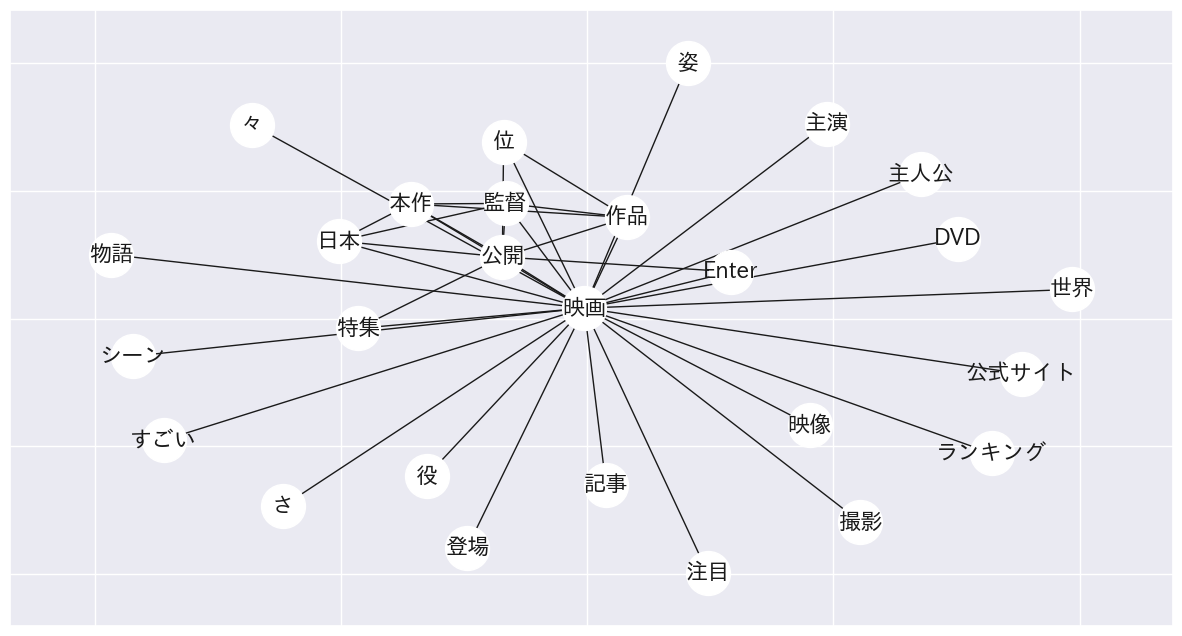

In [ ]:
w1 = []
w2 = []
freq = []
# データフレームの作成
for n,f in top_pair:
    w1.append(n[0])
    w2.append(n[1])
    freq.append(f)
# 可視化用のデータを作成、出現頻度を重み（可視化した時の単語の距離）として設定
weighted_edges = np.array(pd.DataFrame({'first_word': w1, 'second_word': w2, '出現頻度': freq}))
import networkx as nx
G = nx.Graph()
G.add_weighted_edges_from(weighted_edges)

plt.figure(figsize=(15,8))
nx.draw_networkx(G, node_color = "white", node_size = 1000, font_size = 16, font_family = "IPAexGothic")

## langchainによるさらなるテキストのチャンク化
以下のように、langchainにはいくつかのデータ読み込み・splitterライブラリが用意されています。<br>これによって、多様なファイル形式・データ形式に対応し、チャンクしたデータが作成可能です。

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=30,
    chunk_overlap=30,
)

# Transformarモデルで、コンテキストの埋め込みエンコード
ベクトルによる検索を可能にするため、コーパスをembedding（ベクトル空間に埋め込み）します。<br>
今回はOpen AI APIのコストを節約するため、BERTで実施しましたが、LangchainとOpenAI APIを利用し、以下のようなコードでも、コンテキストの埋め込みは可能です。

※ただし、次元数には気を付けてください。

```python
from decouple import config
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores.elastic_vector_search import ElasticVectorSearch

# 環境変数読み込み
OPENAI_API_KEY = config("OPENAI_API_KEY")
INDEX_NAME = config("INDEX_NAME")
ELASTICSEARCH_HOST = config("ELASTICSEARCH_HOST")

embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
vector_store = ElasticVectorSearch(
    elasticsearch_url=ELASTICSEARCH_HOST,
    index_name=INDEX_NAME,
    embedding=embeddings
)

def create_index(vector_store: ElasticVectorSearch):
    docs = get_es_docs()
    vector_store.add_documents(
        docs,
        bulk_kwargs={
            "chunk_size": 500,
            "max_chunk_bytes": 50000000,
        }
    )
```

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import BertModel, BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from tqdm import tqdm

# BERTモデルとトークナイザーのロード
model_name = 'cl-tohoku/bert-base-japanese'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name).to('cuda')  # GPUにモデルをロード

# カテゴリのエンコーディング
label_encoder = LabelEncoder()
category_labels = label_encoder.fit_transform(df['category'])

# 埋め込み層の作成
embedding_dim = 8  # 埋め込みベクトルの次元数
category_embedding = torch.nn.Embedding(len(label_encoder.classes_), embedding_dim).to('cuda')

# データのバッチ処理
batch_size = 32  # バッチサイズを設定

def encode_texts_batch(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512).to('cuda')
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # GPUからCPUに移動してnumpy配列に変換

# タイトルとコンテンツのベクトル化
title_vectors = []
content_vectors = []
category_vectors = []

for i in tqdm(range(0, len(df), batch_size)):
    batch_titles = df['title'][i:i+batch_size].tolist()
    batch_contents = df['content_preprocessed'][i:i+batch_size].tolist()
    batch_categories = category_labels[i:i+batch_size]
    title_vectors.append(encode_texts_batch(batch_titles))
    content_vectors.append(encode_texts_batch(batch_contents))
    with torch.no_grad():
        category_vectors.append(category_embedding(torch.tensor(batch_categories).to('cuda')).cpu().numpy())

title_vectors = np.vstack(title_vectors)
content_vectors = np.vstack(content_vectors)
category_vectors = np.vstack(category_vectors)

df['title_vector'] = list(title_vectors)
df['content_vector'] = list(content_vectors)
df['category_vector'] = list(category_vectors)

df.head()

tokenizer_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/258k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'BertTokenizer'.


pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

100%|██████████| 101/101 [01:45<00:00,  1.05s/it]


title  \
0                      ピクサーが仕掛ける新たな挑戦とは？   
1                      ツイッターの“新掟”にユーザー困惑   
2  【週末映画まとめ読み】木下優樹菜「結婚生活は、できれば途中退場したくない」   
3        【Sports Watch】斎藤佑樹が“イチロー化しつつある”   
4            離婚歴のある男性との交際、過去はやっぱり気になるもの？   

                                             content        category  \
0  　この夏、少女の勇気が試される！　設立25周年を迎えたディズニー／ピクサーが初めて“女性”を...     movie-enter   
1  ツイッターユーザーによって作られた“新ルール”に多くのユーザーが困惑している。\n\n騒動の...      topic-news   
2  　今週1週間に起こった出来事を振り返る「週末映画まとめ読み」。先週末の動員ランキングは2週連...     movie-enter   
3  プロ野球キャンプで一際注目を集めているのが、いわずもがな、北海道日本ハムファイターズの名護キ...    sports-watch   
4  現在独身でも、過去に「離婚歴がある」という人は、年代限らず珍しくない時代である。ちなみに厚生...  dokujo-tsushin   

                                content_preprocessed  \
0   少女 勇気 設立 周年 ディズニー ピクサー 初めて 女性 主人公 映画 メリダとおそろし...   
1   Twitter ユーザー 新ルール ユーザー 困惑 騒動 発端 フォロワー Twitter...   
2   今週 週間 出来事 週末 映画 まとめ 読み 先週末 動員 ランキング 連続 位 怪物くん...   
3   プロ野球 一際 注目 北海道日本ハムファイターズ 名護 ファン マスコミ 目当て 当然 ダ...   
4   現在 独身 過去 離婚 年代 珍しい 時代 厚生労働省 発表 離婚 統計 平成 離婚 総数...   

                                        title_vector  \
0  [-0.039712477, -0.2926763, -0.22434917, -0.244...   
1  [0.0116395885, 0.1861483, -0.07408683, -0.1386...   
2  [0.21389402, 0.17886114, -0.1810853, -0.342015...   
3  [0.2558105, 0.20425256, -0.036174156, -0.31753...   
4  [0.10366043, 0.22117427, -0.17223085, -0.07206...   

                                      content_vector  \
0  [0.15792695, 0.37148786, -0.2602257, -0.159705...   
1  [0.09820193, 0.3447835, -0.21567142, 0.1109515...   
2  [0.2690685, 0.35308868, -0.10107213, -0.187261...   
3  [0.1605008, 0.47370905, -0.0930841, -0.0099827...   
4  [0.41642505, 0.241626, -0.091971144, -0.111332...   

                                     category_vector  
0  [1.4436898, 1.5940454, -0.4686865, -2.4948442,...  
1  [0.6243708, -0.6728493, -1.9313365, -1.0436795...  
2  [1.4436898, 1.5940454, -0.4686865, -2.4948442,...  
3  [-0.33196455, -0.005155022, 0.16078821, -0.333...  
4  [-0.24459049, -0.89005584, -0.21591207, -0.274...

In [ ]:
print(df.head(1))

               title                                            content  \
0  ピクサーが仕掛ける新たな挑戦とは？  　この夏、少女の勇気が試される！　設立25周年を迎えたディズニー／ピクサーが初めて“女性”を...   

      category                               content_preprocessed  \
0  movie-enter   少女 勇気 設立 周年 ディズニー ピクサー 初めて 女性 主人公 映画 メリダとおそろし...   

                                        title_vector  \
0  [-0.039712477, -0.2926763, -0.22434917, -0.244...   

                                      content_vector  \
0  [0.15792695, 0.37148786, -0.2602257, -0.159705...   

                                     category_vector  
0  [1.4436898, 1.5940454, -0.4686865, -2.4948442,...  


In [ ]:
df.shape

(3209, 7)

In [ ]:
df['category'].nunique()

5

## マッピングを使用してインデックスを作成する

次に、必要なマッピングを使用して Elasticsearch インデックスを作成する必要がある。これにより、データを Elasticsearch にインデックス付けできるようになる。

`title_vector` フィールドと `content_vector` フィールドには `dense_vector` フィールド タイプを使用します。これは、Elasticsearch に密なベクトルを保存できるようにする特別なフィールド タイプです。

後で、kNN 検索の「dense_vector」フィールドをターゲットにする必要があります。

In [ ]:
# インデックスマッピングの設定
index_mapping = {
    "mappings": {
        "properties": {
            "title_vector": {
                "type": "dense_vector",
                "dims": 768,
                "index": "true",
                "similarity": "cosine"
            },
            "content_vector": {
                "type": "dense_vector",
                "dims": 768,
                "index": "true",
                "similarity": "cosine"
            },
            "content": {"type": "text"},
            "title": {"type": "text"},
            "vector_id": {"type": "long"}
        }
    }
}

## Elasticsearch へのデータのインデックス付け

次の関数は、Elasticsearch の Bulk API に渡すことができる必要な一括アクションを生成するため、単一のリクエストで複数のドキュメントのインデックスを効率的に作成できる。

この関数は、DataFrame の行ごとに、インデックス付けされる単一のドキュメントを表す辞書を生成する。

In [ ]:
# カテゴリごとのインデックス作成
categories = df['category'].unique()

for category in categories:
    index_name = category
    if client.indices.exists(index=index_name):
        client.indices.delete(index=index_name)
    client.indices.create(index=category, body=index_mapping)

In [ ]:
# データのインデックス化
def generate_docs(df, category):
    for index, row in df[df['category'] == category].iterrows():
        yield {
            "_index": category,
            "_id": index,
            "_source": {
                "title": row['title'],
                "content": row['content'],
                "title_vector": row['title_vector'].tolist(),  # リストに変換
                "content_vector": row['content_vector'].tolist(),  # リストに変換
                "vector_id": index
            }
        }

Python クライアントの [helpers](https://www.elastic.co/guide/en/elasticsearch/client/python-api/current/client-helpers.html#bulk-helpers) を使用して、データを Elasticsearch にインデックス付けします。バルクインサート用APIです

In [ ]:
from elasticsearch.helpers import BulkIndexError, bulk
for category in categories:
    for batch_start in tqdm(range(0, len(df[df['category'] == category]), batch_size)):
        batch_end = min(batch_start + batch_size, len(df[df['category'] == category]))
        batch_dataframe = df[df['category'] == category].iloc[batch_start:batch_end]
        actions = list(generate_docs(batch_dataframe, category))

        try:
            helpers.bulk(client, actions)
        except BulkIndexError as e:
            # エラー詳細の表示
            for error in e.errors:
                print(json.dumps(error, indent=2))

100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


単純な一致クエリを使用してインデックスをテストしてみましょう。

In [ ]:
query = {
    "match": {
        "title": {
            "query": "ピクサーが仕掛ける新たな挑戦とは？"
        }
    }
}

response = client.search(index="movie-enter", query=query)

# 検索結果をデータフレームに変換
def search_results_to_dataframe(response):
    hits = response['hits']['hits']
    data = []
    for hit in hits:
        source = hit['_source']
        source['score'] = hit['_score']
        data.append(source)
    return pd.DataFrame(data)

# 検索結果をデータフレームに変換
df_results = search_results_to_dataframe(response)

# 表示
print(df_results)

# 表形式で表示（Jupyter NotebookやColabの場合）
from IPython.display import display
display(df_results)

                                 title  \
0                    ピクサーが仕掛ける新たな挑戦とは？   
1  “のぼう様”が仕掛けるとんでもない奇襲とは？　コミカルな予告映像が公開   
2      AKB大島優子「楽しみにしていて」、ピクサー最新作で声優に挑戦   
3       【週末映画まとめ読み】人気グラドルが新たなセクシー領域に挑戦   
4   『ターミネーター』と『チャーリーズ・エンジェル』を掛け合わせた面白さ   
5               恐怖顔であなたをみつめる戦慄の“人面つけ麺”   
6    美少女・橋本愛が声優に初挑戦「初めてだからできないのは当たり前！」   
7         【DVDエンター！】童貞とビキニ美女のセイシをかけた戦い   
8              志村けん、全米で大ヒット中の映画で声優に初挑戦   
9     【DVDエンター！】倉科カナが“セイシをかけた”日韓バトルに挑む   

                                             content  \
0  　この夏、少女の勇気が試される！　設立25周年を迎えたディズニー／ピクサーが初めて“女性”を...   
1  　「天下統一目前の秀吉が唯一、落とせなかった城があった」\n\n　累計130万部を突破した大...   
2  　日本を代表するアイドルがハリウッド映画に進出！　『カールじいさんの空飛ぶ家』『トイ・ストー...   
3  　今週1週間に起こった出来事を振り返る「週末映画まとめ読み」。先週末の動員ランキングは、阿部...   
4  　CIA（アメリカ中央情報局）、米大統領の直轄組織であり、外交・国防政策の決定に必要な諜報・...   
5  　器に盛られた「つけ麺」が恐怖の表情で睨みつけている。何なんだ、これは。\n\n　まさか、1...   
6  　ジェームズ・キャメロンやクエンティン・タランティーノらが絶賛し、世界からジャパニメーション...   
7  　『SUPER 8／スーパーエイト』『トランスフォーマー／ダークサイド・ムーン』『世界侵略：...   
8  　日本を代表する“変なおじさん”がハリウッドの“スゴイおじさ

title  \
0                    ピクサーが仕掛ける新たな挑戦とは？   
1  “のぼう様”が仕掛けるとんでもない奇襲とは？　コミカルな予告映像が公開   
2      AKB大島優子「楽しみにしていて」、ピクサー最新作で声優に挑戦   
3       【週末映画まとめ読み】人気グラドルが新たなセクシー領域に挑戦   
4   『ターミネーター』と『チャーリーズ・エンジェル』を掛け合わせた面白さ   
5               恐怖顔であなたをみつめる戦慄の“人面つけ麺”   
6    美少女・橋本愛が声優に初挑戦「初めてだからできないのは当たり前！」   
7         【DVDエンター！】童貞とビキニ美女のセイシをかけた戦い   
8              志村けん、全米で大ヒット中の映画で声優に初挑戦   
9     【DVDエンター！】倉科カナが“セイシをかけた”日韓バトルに挑む   

                                             content  \
0  　この夏、少女の勇気が試される！　設立25周年を迎えたディズニー／ピクサーが初めて“女性”を...   
1  　「天下統一目前の秀吉が唯一、落とせなかった城があった」\n\n　累計130万部を突破した大...   
2  　日本を代表するアイドルがハリウッド映画に進出！　『カールじいさんの空飛ぶ家』『トイ・ストー...   
3  　今週1週間に起こった出来事を振り返る「週末映画まとめ読み」。先週末の動員ランキングは、阿部...   
4  　CIA（アメリカ中央情報局）、米大統領の直轄組織であり、外交・国防政策の決定に必要な諜報・...   
5  　器に盛られた「つけ麺」が恐怖の表情で睨みつけている。何なんだ、これは。\n\n　まさか、1...   
6  　ジェームズ・キャメロンやクエンティン・タランティーノらが絶賛し、世界からジャパニメーション...   
7  　『SUPER 8／スーパーエイト』『トランスフォーマー／ダークサイド・ムーン』『世界侵略：...   
8  　日本を代表する“変なおじさん”がハリウッドの“スゴイおじさん”に変身！？　映画『ロラックス...   
9  　昨年ドラマ「名前をなくした女神」（4〜6月）で“ララちゃんママ”こと意地悪なヤンママを演じ...   

                                        title_vector  \
0  [-0.03971247747540474, -0.29267629981040955, -...   
1  [0.2237161248922348, 0.23424012959003448, 0.00...   
2  [0.19398711621761322, -0.06148553639650345, -0...   
3  [0.19916893541812897, -0.09988582879304886, -0...   
4  [0.0665135309100151, -0.11871060729026794, -0....   
5  [0.01504443772137165, 0.11744141578674316, -0....   
6  [0.2502400279045105, -0.08793994039297104, -0....   
7  [0.06421256810426712, 0.18236225843429565, -0....   
8  [0.11415579169988632, -0.14516614377498627, -0...   
9  [0.23865462839603424, -0.013694400899112225, -...   

                                      content_vector  vector_id      score  
0  [0.15792694687843323, 0.3714878559112549, -0.2...          0  40.960610  
1  [0.2693719267845154, 0.4959840476512909, -0.19...        532  17.670527  
2  [0.22265192866325378, 0.42525339126586914, -0....       1528  14.120502  
3  [0.2830284833908081, 0.34150564670562744, -0.1...       1080  13.381571  
4  [0.07087281346321106, 0.2519236207008362, -0.1...       1439  12.392168  
5  [0.2933329939842224, 0.5133271217346191, -0.04...        317  10.057430  
6  [0.21975357830524445, 0.3386108875274658, -0.2...       1318   9.734082  
7  [0.20990736782550812, 0.537284791469574, -0.25...       1288   9.491435  
8  [0.20859816670417786, 0.428335040807724, -0.31...       2417   9.428713  
9  [0.36902958154678345, 0.46465831995010376, -0....       1322   8.968400

## 検索評価（※標準検索）
検索評価指標は、多様にありますが、標準検索の場合には以下の指標を利用するといいでしょう。

- MRR
- Recall@k
- Precision@k

In [ ]:
# 正解データ
ground_truth_title = "ピクサーが仕掛ける新たな挑戦とは？"
ground_truth_content = "この夏、少女の勇気が試される！　設立25周年を迎えたディズニー／ピクサーが初めて“女性”を..."

# MRRの計算
def calculate_mrr(df_results, ground_truth_title):
    for i, row in enumerate(df_results.itertuples(), start=1):
        if row.title == ground_truth_title:
            return 1 / i
    return 0

# Recall@kの計算
def calculate_recall_at_k(df_results, ground_truth_title, k):
    for i, row in enumerate(df_results.head(k).itertuples(), start=1):
        if row.title == ground_truth_title:
            return 1
    return 0

# 評価
mrr = calculate_mrr(df_results, ground_truth_title)
recall_at_5 = calculate_recall_at_k(df_results, ground_truth_title, 5)
recall_at_10 = calculate_recall_at_k(df_results, ground_truth_title, 10)

print(f"MRR: {mrr}")
print(f"Recall@5: {recall_at_5}")
print(f"Recall@10: {recall_at_10}")

MRR: 1.0
Recall@5: 1
Recall@10: 1


## 埋め込みモデルを使用して質問をエンコードする

セマンティック検索を実行するには、インデックス時にドキュメントをエンコードするのに使用したものと同じ埋め込みモデルを使用してクエリをエンコードする必要があります。

In [ ]:
question = 'ピクサーが仕掛ける新たな挑戦とは？'

# クエリベクトルを生成
def encode_text(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to('cuda')
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

question_embedding = encode_text(question).flatten().tolist()

# 結果を表示
print(question_embedding)

[-0.029075931757688522, -0.17393523454666138, -0.21688024699687958, -0.23389476537704468, -0.028539277613162994, 0.46102720499038696, 0.3051290810108185, -0.10932928323745728, -0.05845320597290993, 0.03060043230652809, 0.08207008987665176, 0.09310878068208694, -0.017766369506716728, 0.0797448679804802, 0.15115973353385925, 0.17516213655471802, 0.011019865982234478, -0.09409132599830627, 0.08154205977916718, 0.5445115566253662, 0.3146139085292816, -0.33099693059921265, -0.16714370250701904, 0.04300226271152496, 0.16158519685268402, -0.2090565711259842, 0.11314952373504639, 0.25794124603271484, 0.25037023425102234, -0.3180225193500519, 0.07903648912906647, -0.18965505063533783, 0.18101854622364044, -0.12393028289079666, 0.2664884030818939, -0.0928003117442131, 0.20973913371562958, -0.11857789009809494, -0.11351366341114044, 0.06011452525854111, -0.5952568650245667, -0.15273119509220123, -0.18912290036678314, 0.29822081327438354, -0.46844393014907837, -0.16060267388820648, -0.224361047148

## セマンティック検索クエリを実行する

これで、エンコードされた質問を使用して Elasticsearch インデックスに対してクエリを実行する準備が整いました。 Elasticsearch [kNN クエリ](https://www.elastic.co/guide/en/elasticsearch/reference/current/knn-search.html) オプションを使用して、k 近傍検索を実行します。

まず、結果をきれいに出力するための小さな関数を定義します。

In [ ]:
# Elasticsearchで検索クエリを実行
def pretty_response(response):
    for hit in response['hits']['hits']:
        id = hit['_id']
        score = hit['_score']
        title = hit['_source']['title']
        text = hit['_source']['content']
        pretty_output = (f"\nID: {id}\nTitle: {title}\nSummary: {text}\nScore: {score}")
        print(pretty_output)

それでは、`kNN` クエリを実行してみましょう。

In [ ]:
response = client.search(
  index="movie-enter",
  knn={
      "field": "content_vector",
      "query_vector": question_embedding,
      "k": 10,
      "num_candidates": 100
  }
)

df_results = search_results_to_dataframe(response)

In [ ]:
# 検索結果をデータフレームに変換
def search_results_to_dataframe(response):
    hits = response['hits']['hits']
    data = []
    for hit in hits:
        source = hit['_source']
        source['score'] = hit['_score']
        source['content_vector'] = np.array(source['content_vector'])  # convert to numpy array
        data.append(source)
    return pd.DataFrame(data)

## 検索評価（※セマンティック検索）
先ほどの標準検索と異なり、クエリ（質問）に対し、コンテキストが埋め込まれたベクトル空間から、どれだけ類似したデータが検索できているかは、コンテキストの類似性を図る必要があります。<br>
こちらも多様にありますが、今回はコサイン類似度を採用します。

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# クエリベクトルを2次元配列に変換
question_embedding_reshaped = np.array(question_embedding).reshape(1, -1)

# コサイン類似度の計算
df_results['cosine_similarity'] = df_results.apply(lambda row: cosine_similarity(question_embedding_reshaped, np.array(row['content_vector']).reshape(1, -1))[0][0], axis=1)

# 表形式で表示
from IPython.display import display
display(df_results[['title', 'content', 'cosine_similarity']])

# 平均コサイン類似度
average_cosine_similarity = df_results['cosine_similarity'].mean()
print(f"Average Cosine Similarity: {average_cosine_similarity}")

# コサイン類似度の最大値
max_cosine_similarity = df_results['cosine_similarity'].max()
print(f"Max Cosine Similarity: {max_cosine_similarity}")

# コサイン類似度の最小値
min_cosine_similarity = df_results['cosine_similarity'].min()
print(f"Min Cosine Similarity: {min_cosine_similarity}")


title  \
0                 長編アニメーション賞はジョニー・デップの『ランゴ』   
1                今からでも間に合う！知ったふりして映画祭デートに誘う   
2       大島優子がここからどう破滅していくのか？　『闇金ウシジマくん』特報解禁   
3       ジャスティン・ティンバーレイク主演『TIME／タイム』の予告映像が公開   
4             「家政婦のミタ」の忽那汐里が声優に初挑戦、健気な妹を演じる   
5      【いちおう妖ヶ劇場】第5話：妖怪集まりゃ、メジャーなんて目じゃーないの巻   
6       【いちおう妖ヶ劇場】第4話：謹賀新年、サイコロの目でサイが飛び出すの巻   
7  「ポケモン」や「ONE PIECE」と同じ賞を獲得したキモかわいいキャラが全国に   
8                 かわいいパンダ写真37枚、仕事の合間に見て癒される   
9                   大島優子、闇金に追われ転落『闇金ウシジマくん』   

                                             content  cosine_similarity  
0  　日本時間27日10時半より開催された、第84回アカデミー賞の授賞式。長編アニメーション賞は...           0.884775  
1  　残すところあと2日となった第24回東京国際映画祭。今までどんなイベントがあったかのおさらい...           0.881213  
2  　“闇金”という禁断の題材をリアルに描いた漫画史上最大の問題作「闇金ウシジマくん」が、映画化...           0.876807  
3  　2012年上半期、注目のノンストップ・アクション・サスペンス『TIME／タイム』が、2月1...           0.879198  
4  　7月7日公開映画『グスコーブドリの伝記』にてメイン声優として、主役のブドリ役に小栗旬、ブド...           0.877947  
5  【前回までのあらすじ】\n　妖怪が住むボロアパートで一人暮らしをする元・お嬢様の勅使河原 栄...           0.877275  
6  　【前回までのあらすじ】\n　ある事情から妖怪が住むアパートに住むことになった元・大富豪の勅...           0.876111  
7  　「クサマダラオオコビト」や「カクレモモジリ」というキャラクターを皆さんはご存じだろうか。発...           0.873598  
8  　2006年、成都パンダ研究基地で体重わずか51グラムの超未熟児で生まれたパンダ「ウーイー」...           0.874255  
9  　映画『闇金ウシジマくん』の公開日が8月25日に決定し、主要キャストにAKB48の大島優子の...           0.869349

Average Cosine Similarity: 0.8770528108051042
Max Cosine Similarity: 0.8847749595591712
Min Cosine Similarity: 0.8693493890231748


# 親インデックス作成

In [ ]:
unique_categories = df['category'].unique()
result_df = pd.DataFrame()

for category in unique_categories:
    subset = df[df['category'] == category].head(5)
    result_df = pd.concat([result_df, subset], ignore_index=True)

# 結果の表示
result_df

# 結果をCSVファイルに出力
result_df.to_csv('output.csv', index=False, encoding='utf-8-sig')

print("CSVファイルに出力しました。")

CSVファイルに出力しました。


## 各カテゴリの要約
movie-enter: 映画に関するニュースやレビュー、映画イベントの情報を含む記事が多いです。<br>
topic-news: 一般的なニュースや社会的な出来事に関する記事が多いです。<br>
sports-watch: スポーツに関するニュースやレビュー、試合の結果や選手に関する情報が多いです。<br>
dokujo-tsushin: 女性向けの生活情報や恋愛、健康、ファッションに関する記事が多いです。<br>
it-life-hack: IT関連のニュースや新製品レビュー、技術情報が多いです。

In [ ]:
# category_vectorの次元数を確認 8次元だと、768に合わない
# print(len(df['category_vector'][0]))

8


In [ ]:
category_summaries = {
    'movie-enter': '映画に関するニュースやレビュー、映画イベントの情報',
    'topic-news': '一般的なニュースや社会的な出来事に関する情報',
    'sports-watch': 'スポーツに関するニュースやレビュー、試合の結果や選手に関する情報',
    'dokujo-tsushin': '女性向けの生活情報や恋愛、健康、ファッションに関する情報',
    'it-life-hack': 'IT関連のニュースや新製品レビュー、技術情報'
}

In [ ]:
parent_index='parent-index-1' #@param

In [ ]:
categories = list(category_summaries.keys())
summaries = list(category_summaries.values())

# バッチ処理でテキストをエンコードする関数
def encode_texts_batch(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512).to('cuda')
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # GPUからCPUに移動してnumpy配列に変換

# 要約のベクトル化
summary_vectors = encode_texts_batch(summaries)

# 親インデックスの作成
index_mapping = {
    "mappings": {
        "properties": {
            "category": {"type": "keyword"},
            "overview_vector": {"type": "dense_vector", "dims": 768}  # category_vectorの次元数に合わせます
        }
    }
}

# 親インデックスの作成
client.indices.create(index=parent_index, body=index_mapping, ignore=400)

# Elasticsearchにデータをインデックス
bulk_data = []
for idx, (category, vector) in enumerate(zip(categories, summary_vectors)):
    bulk_data.append({
        "_index": parent_index,
        "_id": idx,
        "_source": {
            "category": category,
            "overview_vector": vector.tolist()  # ベクトルをリストとして保存
        }
    })

# Bulkインデックス
helpers.bulk(client, bulk_data, refresh=True)

print(f"登録した代表ベクトルの数: {len(bulk_data)}")

登録した代表ベクトルの数: 5


In [ ]:
# 親インデックスに対してセマンティック検索
response = client.search(
    index=parent_index,
    knn={
        "field": "overview_vector",  # 修正点: 正しいフィールド名を指定
        "query_vector": question_embedding,
        "k": 3,
        "num_candidates": 100
    }
)
category = response['hits']['hits']

In [ ]:
# 最も類似したカテゴリを取得
category = response['hits']['hits'][0]['_source']['category']
print(f"最も類似したカテゴリ: {category}")

# 得られたカテゴリを使用して対応する子インデックスを検索
child_index = category  # 子インデックスの名前がカテゴリ名と同じであると仮定

# 子インデックスに対して検索
child_response = client.search(
  index=child_index,
  knn={
      "field": "content_vector",
      "query_vector": question_embedding,
      "k": 10,
      "num_candidates": 100
  }
)

df_results = search_results_to_dataframe(child_response)

# 子インデックスの検索結果を表示
for hit in child_response['hits']['hits']:
    print(f"ID: {hit['_id']}\nTitle: {hit['_source']['title']}\nContent: {hit['_source']['content']}\n")

最も類似したカテゴリ: it-life-hack
ID: 1127
Title: こりゃ商品化は無理！　ユニークなイヤホンジャックカバー（作品）が話題に？
Content: 以前紹介した「色んなアイデアが爆発！　にゃんこ型イヤホンジャックカバーの次は何だ？」に続き、中日ドラゴンズのマスコット「ドアラ型イヤホンジャックカバー」の商品化が決定したようだが、これらのイヤホンジャックカバーに対抗？しているものの、たぶん、おそらく、いやきっと商品化されそうもないイヤホンジャックカバー（の作品）が登場した。

筆者もお名前を存じ上げ、発表会等でお目にかかったこともあるであろうIT系ライターさん（あえて名前は伏せておきます）が作成したというこのイヤホンジャックカバー（の作品）、無駄にディテールに凝っていたりするのは置いておき。大手IT系メディアで取り上げる様子もないので、ここぞとばかりにITライフハックで取り上げさせていただきます（申し訳ないですが謝礼は出せません・・・悪しからず）。むしろ、今後何かオモシロネタでもございましたら、うちにもお声をかけていただければと思います。

togetter：にゃんこ型イヤホンジャックカバーに対抗して■●△型イヤホンジャックカバー作った

■ニコニコショッピング（仮）にゃんこ型イヤホンジャックカバー作ってみた
■ニコニコショッピング（仮）ドアラ型イヤホンジャックカバーを作ってみた（すごいじゃま）


ID: 2356
Title: 懐かしのヒーローが続々！　名アニメーターが描くヒーローイラストが話題に
Content: 1984年の北斗の拳から2011年の輪るピングドラムといったメジャー作品を手掛けてるアニメーターの羽山淳一氏が往年のヒーローやアニメの名わき役のイラストを描いてはツイッターにアップしている。そのクオリティの素晴らしさが話題になっている。

いい加減いい年の筆者は、イラストになっているウルトラセブンやガッチャマンといった往年のヒーロー、ファーストガンダムのランバラルやサイボーグ009のメンバーといった主人公以外の人物など、ほとんどリアルタイムで知っているモノばかりだ。羽山氏の職業がら当然とも言えるのだが、あまりにもバラエティ豊かなピックアップなので、仕事抜きでやっぱりこういったアニメが好きなんだろうなという単純な感想を持った。



成功！これで、Elasticsearch をベクトル データベースとして使用して、エンベディングを保存し、OpenAI [`embeddings`](https://platform.openai.com/docs/api-reference/embeddings) エンドポイントを呼び出してクエリをエンコードし、セマンティックを実行する方法がわかりました。 [kNN 検索](https://www.elastic.co/guide/en/elasticsearch/reference/current/knn-search.html) を使用して検索し、上位の結果を見つけます。

さまざまなクエリを試してみてください。独自のデータを試してみたい場合は、さまざまな埋め込みモデルを試すことができます。

これで、[チャット完了](https://platform.openai.com/docs/api-reference/chat) API を使用して、上位の検索結果を追加のコンテキストとして使用して生成 AI マジックを実行できるようになりました。

## RAG（検索拡張生成）
### Langchainを使用する
LLM モデルを検索モデルとともに使用することは、検索拡張生成 (RAG) として知られています。関連するドキュメントを取得するという、Elasticsearch が最も得意とする機能を実行するために Elasticsearch を使用しています。次に、LLM を使用して、取得したドキュメントをコンテキストとして使用して、概要の生成や質問への回答などのタスクを実行します。

モデルは、上位の kNN ヒットをコンテキストとして使用して、質問に対する応答を生成します。 「メッセージ」リストを使用して、モデルに合わせてプロンプトを作成します。この例では、「gpt-3.5-turbo」モデルを使用しています。

**LLMの定義**

In [ ]:
from langchain.chat_models import ChatOpenAI

def get_llm() -> ChatOpenAI:
    return ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, openai_api_key=OPENAI_API_KEY)

ベクトルデータベースの接続
chatメソッドでは、先程定義したLLMのモデルを使って、ベクトルデータベースとの連携を定義します。

In [ ]:
from langchain import agents
from langchain.chains import VectorDBQAWithSourcesChain

def chat(message: str) -> str:
    llm = setting.get_llm()
    qa = VectorDBQAWithSourcesChain.from_chain_type(llm, chain_type="map_reduce", vectorstore=setting.get_vector_store())

次に、LangChainのAgentとToolsを定義します。この定義は、LLMとベクトルデータベースの連携の要となります。

Agentは、ユーザーの指示を達成するために「思考→行動→観察」を行う、まさにロボットのような機能です。入力テキストの内容に応じて、どのToolを使えばよいかを考えてくれます。

今回使用するToolは、「LLM(GPT)」と「ベクトルデータベース(Elasticsearch)」です。

Toolには、nameとdescriptionを指定します。これにより、AgentはどのToolを使うべきかを判断します。これらの指定は英語で行う方が誤作動が少ないようですが、LLMの精度が上がれば改善されるかもしれません。

これで、質問とテキストを OpenAI の チャット完了 API に送信できるようになりました。

In [ ]:
from langchain import agents
from langchain.agents import AgentType, Tool


def chat(message: str) -> str:
    ...
    tools = [
        Tool(
            name="news_searcher",
            func=qa,
            description="useful for when you need to answer questions about the most news picks."
        )
    ]

    agent = agents.initialize_agent(tools, llm=llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True)

In [ ]:
from langchain.prompts import PromptTemplate


def _get_question_prompt(text: str) -> str:
    translate_template = """
        下記の質問に日本語で答えてください。また、参照元についても教えて下さい。
        質問：{question}
        回答：
        """
    prompt = PromptTemplate(
        input_variables=["question"],
        template=translate_template,
    )

    return prompt.format(question=text)

In [ ]:
def chat(message: str) -> str:
    ...
    question = _get_question_prompt(message)
    answer = agent.run(question)
    return answer

In [ ]:
print("------------------------------------------------------------")
print(chatbot_engine.chat('ピクサーが仕掛ける新たな挑戦とは？'))
print("------------------------------------------------------------")

------------------------------------------------------------
ピクサーが仕掛ける新たな挑戦は、ジョニー・デップが声優に挑戦した『ランゴ』という作品におけるキャラクターの動きを彼の動きを元につくられるという斬新なアプローチでした。
------------------------------------------------------------


### コードの説明

OpenAIのモデルを使用して応答を生成します。
- システムメッセージとユーザーメッセージをモデルに送信します。
- システムメッセージはアシスタントの役割を「役に立つアシスタント」に設定します。
- ユーザーメッセージには、元のkNNクエリで指定された質問といくつかの入力テキストが含まれています。
- モデルからの応答は `summary.choices` 変数に保存されます。

## 次のステップ

これで、Elasticsearchをベクトルデータベースとして使用し、Transformarの[`embeddings`](https://platform.openai.com/docs/api-reference/embeddings) を実施して、クエリをエンコードし、[kNN 検索](https://www.elastic.co/guide/en/elasticsearch/reference/current/knn-search.html) を使用してセマンティック検索を行い、上位の結果を見つける方法がわかりました。

これは、ElasticsearchとOpenAIのモデルを組み合わせて、エンベディングを保存し、セマンティック検索を実行し、検索を強化する一例です。RAGを使用すると、追加のコンテキストを取り入れたモデルを活用することで、コストのかかるモデルのトレーニングや微調整を避けられます。

この方法を独自の実験の参考にしてください。

会話をさまざまなユースケースに適応させるためには、システムメッセージをカスタマイズしてアシスタントの動作やペルソナを定義し、ユーザーメッセージを調整して要約や質問への回答などのタスクと希望する応答形式を指定してください。